In [3]:
import os
import xml
import shutil
import numpy as np
from os.path import join

import cv2
import scipy.io
from PIL import Image
from skimage import draw
from skimage.draw import polygon_perimeter

In [4]:
def mkdir(path):
    '''Make new dir'''
    if not os.path.exists(path):
        os.mkdir(path)

# MoNuSeg

In [9]:
def_im_size = (1000, 1000) # original image size
im_size = (1000, 1000)#(500, 500)

In [3]:
# NEW DATA FOLDERS

data_dir = '../data/MoNuSeg_data'

train_imgs_dir = join(data_dir, 'train_images')
test_imgs_dir = join(data_dir, 'test_images')
all_masks_dir = join(data_dir, 'all_masks')
all_countuors_dir = join(data_dir, 'all_contours')

mkdir(data_dir)
mkdir(train_imgs_dir)
mkdir(test_imgs_dir)
mkdir(all_masks_dir)
mkdir(all_countuors_dir)


In [4]:
# RAW DATA FOLDERS
raw_data_dir = '../data/MoNuSeg'

raw_train_dir = join(raw_data_dir, 'MoNuSegTrainingData')
raw_train_imgs_dir = join(raw_train_dir, 'TissueImages')
raw_train_anno_dir = join(raw_train_dir, 'Annotations')

raw_test_dir = join(raw_data_dir, 'MoNuSegTestData')
raw_test_imgs_dir = join(raw_test_dir, 'TissueImages')
raw_test_anno_dir = join(raw_test_dir, 'Annotations')


In [6]:
# Copy Images to new folder    
def copy_images(src_img_dir, dst_img_dir, im_size=None, train=True):
    '''Copy Images to new folder'''
    imgs_fn = sorted([p for p in os.listdir(src_img_dir) if not 'ipynb' in p])

    for filename in imgs_fn:
        src = join(src_img_dir, filename)
        dst = join(dst_img_dir, filename[:-4]+'.png')
        
        img = Image.open(src)
        if im_size:
            img = img.resize(im_size)
        img.save(dst, 'PNG')
    
# Train
copy_images(raw_train_imgs_dir, train_imgs_dir, im_size)

# Test
copy_images(raw_test_imgs_dir, test_imgs_dir, im_size)
    

In [7]:
# Made Masks and save to new folder
def get_coordinates(regions):
    # for each region tag
    # get a list of all the vertexes (which are in order)
    xy = []
    for region in regions:
        verticies = region.getElementsByTagName('Vertex')
        xy.append([])

        # iterate through all verticies
        for vertex in verticies:
            # get the x value of that verte
            x = float(vertex.getAttribute('X'))
            # get the y value of that vertex
            y = float(vertex.getAttribute('Y'))

            xy[-1].append([x,y])
    return xy

def poly2mask(vertex_row_coords, vertex_col_coords, shape):
    # https://github.com/scikit-image/scikit-image/issues/1103#issuecomment-52378754
    fill_row_coords, fill_col_coords = draw.polygon(
        vertex_row_coords, vertex_col_coords, shape)
    mask = np.zeros(shape, dtype=np.bool)
    mask[fill_row_coords, fill_col_coords] = True
    return mask


def coords_to_mask(coords, im_size):
    binary_mask = np.zeros(im_size, dtype=np.bool)
    color_mask = np.zeros((im_size[0], im_size[1], 3), dtype=np.int32)
    
    for i in range(len(coords)):
        points = np.array(coords[i])
        small_x = points[:,0]
        small_y = points[:,1]

        # make a mask and add it to the current mask
        # this addition makes it obvious when more than 
        # 1 layer overlap each.
        # Other, can be changed to simply an OR 
        # depending on application.

        polygon = poly2mask(small_x, small_y, im_size)

        binary_mask |= polygon

    return binary_mask.T

def coords_to_contours(coords, im_size):
    edges = np.zeros(im_size, dtype=np.uint8)
    
    for coord in coords:
        c = np.array(coord)
        # Poligon has to have at least 3 coordinats
        if len(c) > 2: 
            rr, cc = polygon_perimeter(c[:,1], c[:,0], shape=edges.shape,clip=True)
            edges[rr, cc] = 255

    return edges

def copy_masks(ann_dir, im_size):
#     ann_dir = raw_train_anno_dir
    
    # Start of the function
    anns_fn = sorted([p for p in os.listdir(ann_dir) if not 'ipynb' in p])

    for i, filename in enumerate(anns_fn):
        print('[{:2d}/{:3d}] {}'.format(i+1, len(anns_fn), filename))
        # Get annotation file
        file_path = join(ann_dir, filename)
        doc = xml.dom.minidom.parse(file_path)

        # Get Regions info
        regions = doc.getElementsByTagName('Region')
        coords = get_coordinates(regions)

        # Compute binary mask  
        binary_mask = coords_to_mask(coords, def_im_size)

        # Compute countuors
        countuors_mask = coords_to_contours(coords, def_im_size)

        # Save masks
        dst_bi = join(all_masks_dir, filename[:-4]+'.png')
        dst_co = join(all_countuors_dir, filename[:-4]+'.png')

        Image.fromarray(binary_mask).resize(im_size).save(dst_bi, 'PNG')
        Image.fromarray(countuors_mask).resize(im_size).save(dst_co, 'PNG')


In [8]:
print('Train masks generation...')
copy_masks(raw_train_anno_dir, im_size)
print('Test masks generation...')
copy_masks(raw_test_anno_dir, im_size)

Train masks generation...
[ 1/ 30] TCGA-18-5592-01Z-00-DX1.xml
[ 2/ 30] TCGA-21-5784-01Z-00-DX1.xml
[ 3/ 30] TCGA-21-5786-01Z-00-DX1.xml
[ 4/ 30] TCGA-38-6178-01Z-00-DX1.xml
[ 5/ 30] TCGA-49-4488-01Z-00-DX1.xml
[ 6/ 30] TCGA-50-5931-01Z-00-DX1.xml
[ 7/ 30] TCGA-A7-A13E-01Z-00-DX1.xml
[ 8/ 30] TCGA-A7-A13F-01Z-00-DX1.xml
[ 9/ 30] TCGA-AR-A1AK-01Z-00-DX1.xml
[10/ 30] TCGA-AR-A1AS-01Z-00-DX1.xml
[11/ 30] TCGA-AY-A8YK-01A-01-TS1.xml
[12/ 30] TCGA-B0-5698-01Z-00-DX1.xml
[13/ 30] TCGA-B0-5710-01Z-00-DX1.xml
[14/ 30] TCGA-B0-5711-01Z-00-DX1.xml
[15/ 30] TCGA-CH-5767-01Z-00-DX1.xml
[16/ 30] TCGA-DK-A2I6-01A-01-TS1.xml
[17/ 30] TCGA-E2-A14V-01Z-00-DX1.xml
[18/ 30] TCGA-E2-A1B5-01Z-00-DX1.xml
[19/ 30] TCGA-G2-A2EK-01A-02-TSB.xml
[20/ 30] TCGA-G9-6336-01Z-00-DX1.xml
[21/ 30] TCGA-G9-6348-01Z-00-DX1.xml
[22/ 30] TCGA-G9-6356-01Z-00-DX1.xml
[23/ 30] TCGA-G9-6362-01Z-00-DX1.xml
[24/ 30] TCGA-G9-6363-01Z-00-DX1.xml
[25/ 30] TCGA-HE-7128-01Z-00-DX1.xml
[26/ 30] TCGA-HE-7129-01Z-00-DX1.xml
[27/ 30] TCG

# CPM17

In [66]:
'''
+ Copy Images to new folder
    + Train
    + Test
- Copy Masks to new folder
    - Make Masks train
    - Make Masks test
- Copy Countuors to new folder
    - Make Countuors train
    - Make Countuors test
'''

'\n+ Copy Images to new folder\n    + Train\n    + Test\n- Copy Masks to new folder\n    - Make Masks train\n    - Make Masks test\n- Copy Countuors to new folder\n    - Make Countuors train\n    - Make Countuors test\n'

In [67]:
im_size = (600,600)

In [68]:
# NEW DATAFOLDERS

data_dir = '../data/CPM17_data'

train_imgs_dir = join(data_dir, 'train_images')
test_imgs_dir = join(data_dir, 'test_images')
all_masks_dir = join(data_dir, 'all_masks')
all_countuors_dir = join(data_dir, 'all_contours')

mkdir(data_dir)
mkdir(train_imgs_dir)
mkdir(test_imgs_dir)
mkdir(all_masks_dir)
mkdir(all_countuors_dir)


In [69]:
# RAW DATA FOLDERS
raw_data_dir = '../data/CPM-17/cpm17'

raw_train_dir = join(raw_data_dir, 'train')
raw_train_imgs_dir = join(raw_train_dir, 'Images')
raw_train_anno_dir = join(raw_train_dir, 'Labels')

raw_test_dir = join(raw_data_dir, 'test')
raw_test_imgs_dir = join(raw_test_dir, 'Images')
raw_test_anno_dir = join(raw_test_dir, 'Labels')


In [86]:
def copy_images(src_img_dir, dst_img_dir, prefix=None, im_size=None):
    '''Copy Images to new folder'''
    imgs_fn = sorted([p for p in os.listdir(src_img_dir) if not 'ipynb' in p])

    for filename in imgs_fn:
        src = join(src_img_dir, filename)
        dst = join(dst_img_dir, filename[:-4]+'.png')
        if prefix:
            dst = join(dst_img_dir, filename[:-4]+prefix+'.png')
        
        img = Image.open(src).convert('RGB')

        if im_size:
            img = img.resize(im_size)
        img.save(dst, 'PNG')

In [71]:
# Copy images
# Train
copy_images(raw_train_imgs_dir, train_imgs_dir, prefix='_train', im_size=im_size)

# Test
copy_images(raw_test_imgs_dir, test_imgs_dir, prefix='_test', im_size=im_size)


In [85]:
def copy_masks(labels_path, prefix=None, im_size=None):
    '''Function for masks copy'''
    labels_filenames = sorted([p for p in os.listdir(labels_path) if not 'ipynb' in p])

    for filename in labels_filenames:
        file_path = join(labels_path, filename)

        mat = scipy.io.loadmat(file_path)

        # Make binary mask
        binary_mask = mat['inst_map']
        binary_mask = (binary_mask > 0).astype(np.uint8) * 255

        # Save mask
        dst_bi = join(all_masks_dir, file_path.split('/')[-1][:-4]+'.png')
        if prefix:
            dst_bi = join(all_masks_dir, file_path.split('/')[-1][:-4]+prefix+'.png')
           
        img = Image.fromarray(binary_mask)
        if im_size:
            img = img.resize(im_size)
        img.save(dst_bi, 'PNG')


In [73]:
# Copy train masks
copy_masks(raw_train_anno_dir, prefix='_train', im_size=im_size)

# Copy test masks
copy_masks(raw_test_anno_dir, prefix='_test', im_size=im_size)


In [84]:
def copy_countur(labels_path, prefix=None, im_size=None):
    labels_filenames = sorted([p for p in os.listdir(labels_path) if not 'ipynb' in p])

    for filename in labels_filenames:
        # Load instance mask
        file_path = join(labels_path, filename)
        mat = scipy.io.loadmat(file_path)
        mask = mat['inst_map'].astype(int)
        mask = np.repeat(mask[:,:,np.newaxis], 3, axis=2) 

        # Create output counturs array as mask
        counturs = np.zeros_like(mask[:,:,0], dtype='uint8')

        # Number of instances
        n_instance = mask[:,:,0].max()

        # Generate countur for each instance
        for n in range(n_instance):
            img1 = mask[:,:,0] == n + 1
            img1 = img1.astype('uint8') * 255

            idx = cv2.findContours(img1,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)[1][0]

            counturs[idx[:,0,0],idx[:,0,1]] = 255

        # Save counturs
        dst_co = join(all_countuors_dir, filename[:-4]+'.png')
        if prefix:
            dst_co = join(all_countuors_dir, filename[:-4]+prefix+'.png')
        
        img = Image.fromarray(counturs)
        if im_size:
            img = img.resize(im_size)
        img.rotate(-90).transpose(Image.FLIP_LEFT_RIGHT).save(dst_co, 'PNG')


In [75]:
# Copy train countur 
copy_countur(raw_train_anno_dir, prefix='_train', im_size=im_size)

# Copy test countur 
copy_countur(raw_test_anno_dir, prefix='_test', im_size=im_size)

# CoNSeP

In [87]:
# NEW DATAFOLDERS

data_dir = '../data/CoNSeP_data'

train_imgs_dir = join(data_dir, 'train_images')
test_imgs_dir = join(data_dir, 'test_images')
all_masks_dir = join(data_dir, 'all_masks')
all_countuors_dir = join(data_dir, 'all_contours')

mkdir(data_dir)
mkdir(train_imgs_dir)
mkdir(test_imgs_dir)
mkdir(all_masks_dir)
mkdir(all_countuors_dir)


In [88]:
# RAW DATA FOLDERS
raw_data_dir = '../data/CoNSeP'

raw_train_dir = join(raw_data_dir, 'Train')
raw_train_imgs_dir = join(raw_train_dir, 'Images')
raw_train_anno_dir = join(raw_train_dir, 'Labels')

raw_test_dir = join(raw_data_dir, 'Test')
raw_test_imgs_dir = join(raw_test_dir, 'Images')
raw_test_anno_dir = join(raw_test_dir, 'Labels')


In [89]:
# Copy images
# Train
copy_images(raw_train_imgs_dir, train_imgs_dir)

# Test
copy_images(raw_test_imgs_dir, test_imgs_dir)


In [90]:
# Copy train masks
copy_masks(raw_train_anno_dir)

# Copy test masks
copy_masks(raw_test_anno_dir)


In [91]:
# Copy train countur 
copy_countur(raw_train_anno_dir)

# Copy test countur 
copy_countur(raw_test_anno_dir)

# Generate data for semi supervised model

In [126]:
def_im_size = (1000, 1000) # original image size
im_size = (500, 500)
global prefix, postfix
prefix = 2007
postfix = 0
max_classes = 300

'0042'

## MONUSEG

In [127]:
%pwd

'/home/ivan/HD/ivan/cancer_room/Triple_U-net'

In [128]:
# NEW DATA FOLDERS

data_dir = '../../homeworks/ACV/FP/HIST'
img_dir = join(data_dir, 'JPEGImages')
cls_labels_path = join(data_dir, 'cls_labels.npy')

mkdir(data_dir)
mkdir(img_dir)


In [129]:
# RAW DATA FOLDERS
raw_data_dir = '../data/MoNuSeg'

raw_train_dir = join(raw_data_dir, 'MoNuSegTrainingData')
raw_train_imgs_dir = join(raw_train_dir, 'TissueImages')
raw_train_anno_dir = join(raw_train_dir, 'Annotations')

raw_test_dir = join(raw_data_dir, 'MoNuSegTestData')
raw_test_imgs_dir = join(raw_test_dir, 'TissueImages')
raw_test_anno_dir = join(raw_test_dir, 'Annotations')


In [135]:
# Copy Images to new folder    
def copy_images(src_img_dir, dst_img_dir, im_size=None, train=None):
    '''Copy Images to new folder'''
    global prefix, postfix
    imgs_fn = sorted([p for p in os.listdir(src_img_dir) if not 'ipynb' in p])

    for filename in imgs_fn:
        _filename = str(prefix)+'_'+str(postfix).zfill(4)
        src = join(src_img_dir, filename)
        dst = join(dst_img_dir, _filename+'.jpg')
        
        img = Image.open(src)
        if im_size:
            img = img.resize(im_size)
        img.save(dst, 'JPEG')
        
        if train:
            train_labels_fn = join(*img_dir.split('/')[:-1], 'train.txt')
            with open(train_labels_fn, 'a') as file:
                file.write(_filename + '\n')
        else:
            test_labels_fn = join(*img_dir.split('/')[:-1], 'test.txt')
            with open(test_labels_fn, 'a') as file:
                file.write(_filename + '\n')
        postfix += 1
        

# Train
copy_images(raw_train_imgs_dir, img_dir, im_size, train=True)

# Test
copy_images(raw_test_imgs_dir, img_dir, im_size, train=False)
    

In [138]:
int(str(prefix)+str(postfix).zfill(4))

20070044

In [140]:
postfix = 0
def determine_class(ann_dir, max_classes):
    # Start of the function
    global prefix, postfix
    anns_fn = sorted([p for p in os.listdir(ann_dir) if not 'ipynb' in p])
    classes = {}
    
    for i, filename in enumerate(anns_fn):
        print('[{:2d}/{:3d}] {}'.format(i+1, len(anns_fn), filename))
        # Get annotation file
        file_path = join(ann_dir, filename)
        doc = xml.dom.minidom.parse(file_path)

        # Get Regions info
        regions = doc.getElementsByTagName('Region')
        
        onehot = np.zeros(max_classes)
        onehot[len(regions) // 10] = 1
        classes[int(str(prefix)+str(postfix).zfill(4))] = onehot
        postfix += 1
    return classes

print('Train masks generation...')
train_class = determine_class(raw_train_anno_dir, max_classes)
print('Test masks generation...')
test_class = determine_class(raw_test_anno_dir, max_classes)

Train masks generation...
[ 1/ 30] TCGA-18-5592-01Z-00-DX1.xml
[ 2/ 30] TCGA-21-5784-01Z-00-DX1.xml
[ 3/ 30] TCGA-21-5786-01Z-00-DX1.xml
[ 4/ 30] TCGA-38-6178-01Z-00-DX1.xml
[ 5/ 30] TCGA-49-4488-01Z-00-DX1.xml
[ 6/ 30] TCGA-50-5931-01Z-00-DX1.xml
[ 7/ 30] TCGA-A7-A13E-01Z-00-DX1.xml
[ 8/ 30] TCGA-A7-A13F-01Z-00-DX1.xml
[ 9/ 30] TCGA-AR-A1AK-01Z-00-DX1.xml
[10/ 30] TCGA-AR-A1AS-01Z-00-DX1.xml
[11/ 30] TCGA-AY-A8YK-01A-01-TS1.xml
[12/ 30] TCGA-B0-5698-01Z-00-DX1.xml
[13/ 30] TCGA-B0-5710-01Z-00-DX1.xml
[14/ 30] TCGA-B0-5711-01Z-00-DX1.xml
[15/ 30] TCGA-CH-5767-01Z-00-DX1.xml
[16/ 30] TCGA-DK-A2I6-01A-01-TS1.xml
[17/ 30] TCGA-E2-A14V-01Z-00-DX1.xml
[18/ 30] TCGA-E2-A1B5-01Z-00-DX1.xml
[19/ 30] TCGA-G2-A2EK-01A-02-TSB.xml
[20/ 30] TCGA-G9-6336-01Z-00-DX1.xml
[21/ 30] TCGA-G9-6348-01Z-00-DX1.xml
[22/ 30] TCGA-G9-6356-01Z-00-DX1.xml
[23/ 30] TCGA-G9-6362-01Z-00-DX1.xml
[24/ 30] TCGA-G9-6363-01Z-00-DX1.xml
[25/ 30] TCGA-HE-7128-01Z-00-DX1.xml
[26/ 30] TCGA-HE-7129-01Z-00-DX1.xml
[27/ 30] TCG

In [141]:
new_d = train_class
new_d.update(test_class)
np.save(cls_labels_path, new_d)

[ 480  750  440  420  550  440  740  350  430  400 1300 1070 1360 1200
  720  340  370  320  400  440  390  440  470  350 1070 1580 1860 1390
  360 1160  570  810  440  440  520  350  670  460  460  350  320  240
  530  470  570  810  440  440  520  350  670  460  460  350  320  240
  530  470]


/home/ivan/tools/anaconda3/envs/bbn/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in floor_divide
  # Remove the CWD from sys.path while we load stuff.


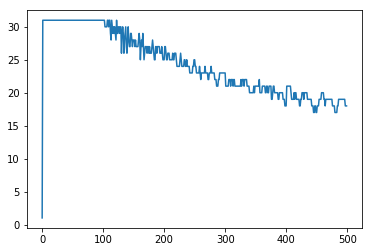

In [81]:
import matplotlib.pyplot as plt

l = list(train_class.values()) + list(test_class.values())
l = np.argmax(l,1) * 100

# print(len(np.unique(l // 10)))

x = []
for i in range(500):
    x += [len(np.unique(l // i))]
    
print(l // 10)
plt.plot(np.arange(500), x)
